### Image Denoising

We will use a convolutional autoencoder to work on an image denoising problem. We will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [ ]:
import keras
import numpy as np
from keras import layers
from keras import regularizers
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
noise_factor = 0.5

'''
np.random.normal(): 
loc: (Mean) where the peak of the bell exists
scale: (Standard Deviation) how flat the graph distribution should be
size: The shape of the returned array
'''

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [ ]:
'''
np.clip():
a : Array containing elements to clip.
a_min : Minimum value. If None, clipping is not performed on lower interval edge. 
Not more than one of a_min and a_max may be None.
a_max : Maximum value.

Ex:
in_array = [1, 2, 3, 4, 5, 6, 7, 8 ]
out_array = np.clip(in_array, a_min = 2, a_max = 6)

Output :
Input array :  [1, 2, 3, 4, 5, 6, 7, 8]
Output array :  [2 2 3 4 5 6 6 6]
'''
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

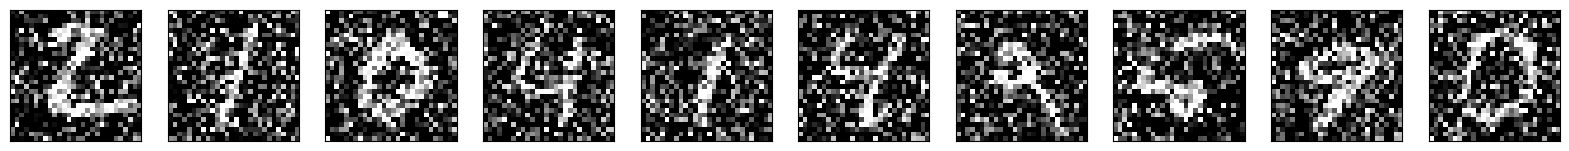

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

'''
The resulting output, when using the "valid" padding option, has a spatial shape
(number of rows or columns) of: 
output_shape = math.floor((input_shape - pool_size) / strides) + 1 (when input_shape >= pool_size)

The resulting output shape when using the "same" padding option is: 
output_shape = math.floor((input_shape - 1) / strides) + 1;
'''

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 16s 8ms/step - loss: 0.1654 - val_loss: 0.1158
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1123 - val_loss: 0.1084
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1075 - val_loss: 0.1049
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1043 - val_loss: 0.1022
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1023 - val_loss: 0.1010
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1009 - val_loss: 0.0995
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0999 - val_loss: 0.0987
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0992 - val_loss: 0.0989
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0986 - val_loss: 0.0975
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0980 - val_l

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/tmp/tb

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-04-07 12:20:59.412805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3.9/dist-packages/tensorboard_data_server/bin/server)
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server 

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 1s 3ms/step


In [ ]:
def plot_autoencoded_imgs(n=10):
  plt.figure(figsize=(20, 4))
  
  for i in range(1, n + 1):
      # Display original
      ax = plt.subplot(2, n, i)
      plt.imshow(x_test_noisy[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, n, i + n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

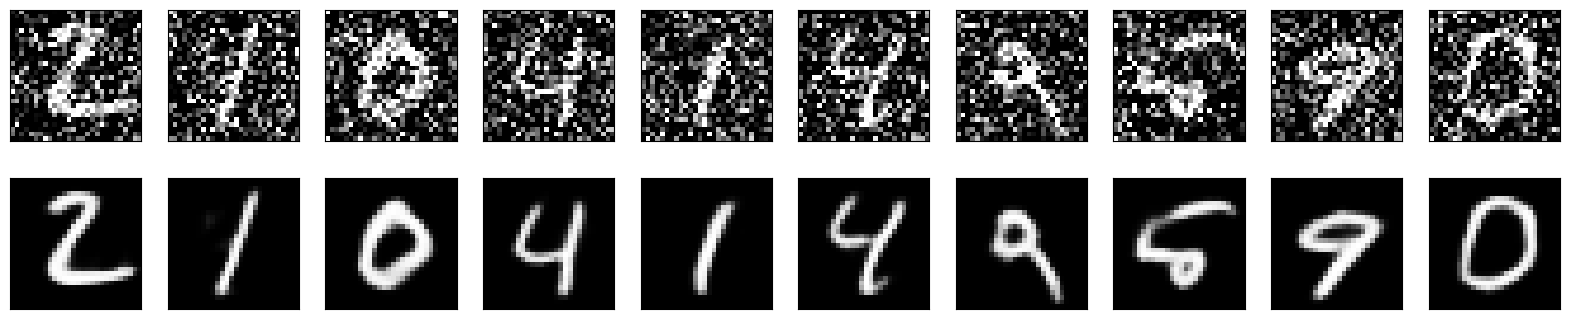

In [ ]:
plot_autoencoded_imgs()

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models

### Reference

https://blog.keras.io/building-autoencoders-in-keras.html